## Preprocessing the dataset

Read the dataset:

In [45]:
import itertools

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

column_labels = [
	'Area',
	'Perimeter',
	'Compactness',
	'Length of kernel',
	'Width of kernel',
	'Asymmetry coefficient',
	'Length of the kernel groove',
	'Numerical class label',
]
df = pd.read_csv(
	'data/seeds.tsv',
	sep='\t',
	header=None,
	names=column_labels
)
df.head()

,Area,Perimeter,Compactness,Length of kernel,Width of kernel,Asymmetry coefficient,Length of the kernel groove,Numerical class label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Scale the dataset using a normalizer:

In [46]:
scaler = StandardScaler()

scaled_data = pd.DataFrame(
	scaler.fit_transform(
		df.drop(columns="Numerical class label")
	),
	columns=column_labels[:-1]
)
scaled_df = pd.concat(
	[scaled_data, df["Numerical class label"]],
	axis=1
)
scaled_df.head()

,Area,Perimeter,Compactness,Length of kernel,Width of kernel,Asymmetry coefficient,Length of the kernel groove,Numerical class label
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577,1
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013,1
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192,1
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983,1
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356,1


## Determining the appropriate number of clusters

Iterating over a range of cluster numbers, determine the optimal number of clusters using the elbow method:

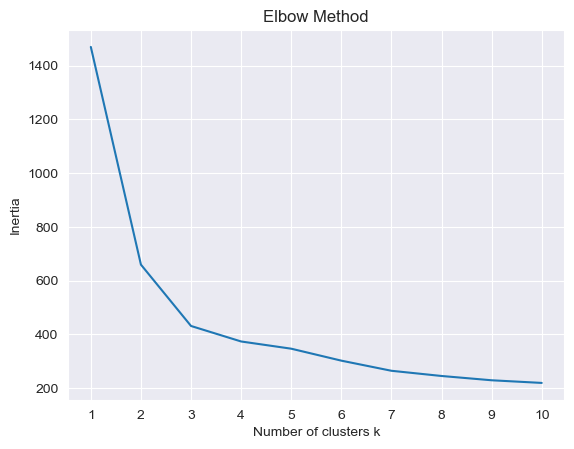

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = range(1, 11)
inertia = []
for i in k:
	kmeans = KMeans(
		n_clusters=i,
		random_state=0,
		n_init="auto"
	).fit(scaled_data)
	inertia.append(kmeans.inertia_)

plt.plot(k, inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.xticks(k)
plt.savefig("figures/elbow_method.png")

We can see that the optimal number of clusters is $3$.

## Visualizing the classes

Scatterplot the pairs of features, coloring the points according to the cluster they belong to:

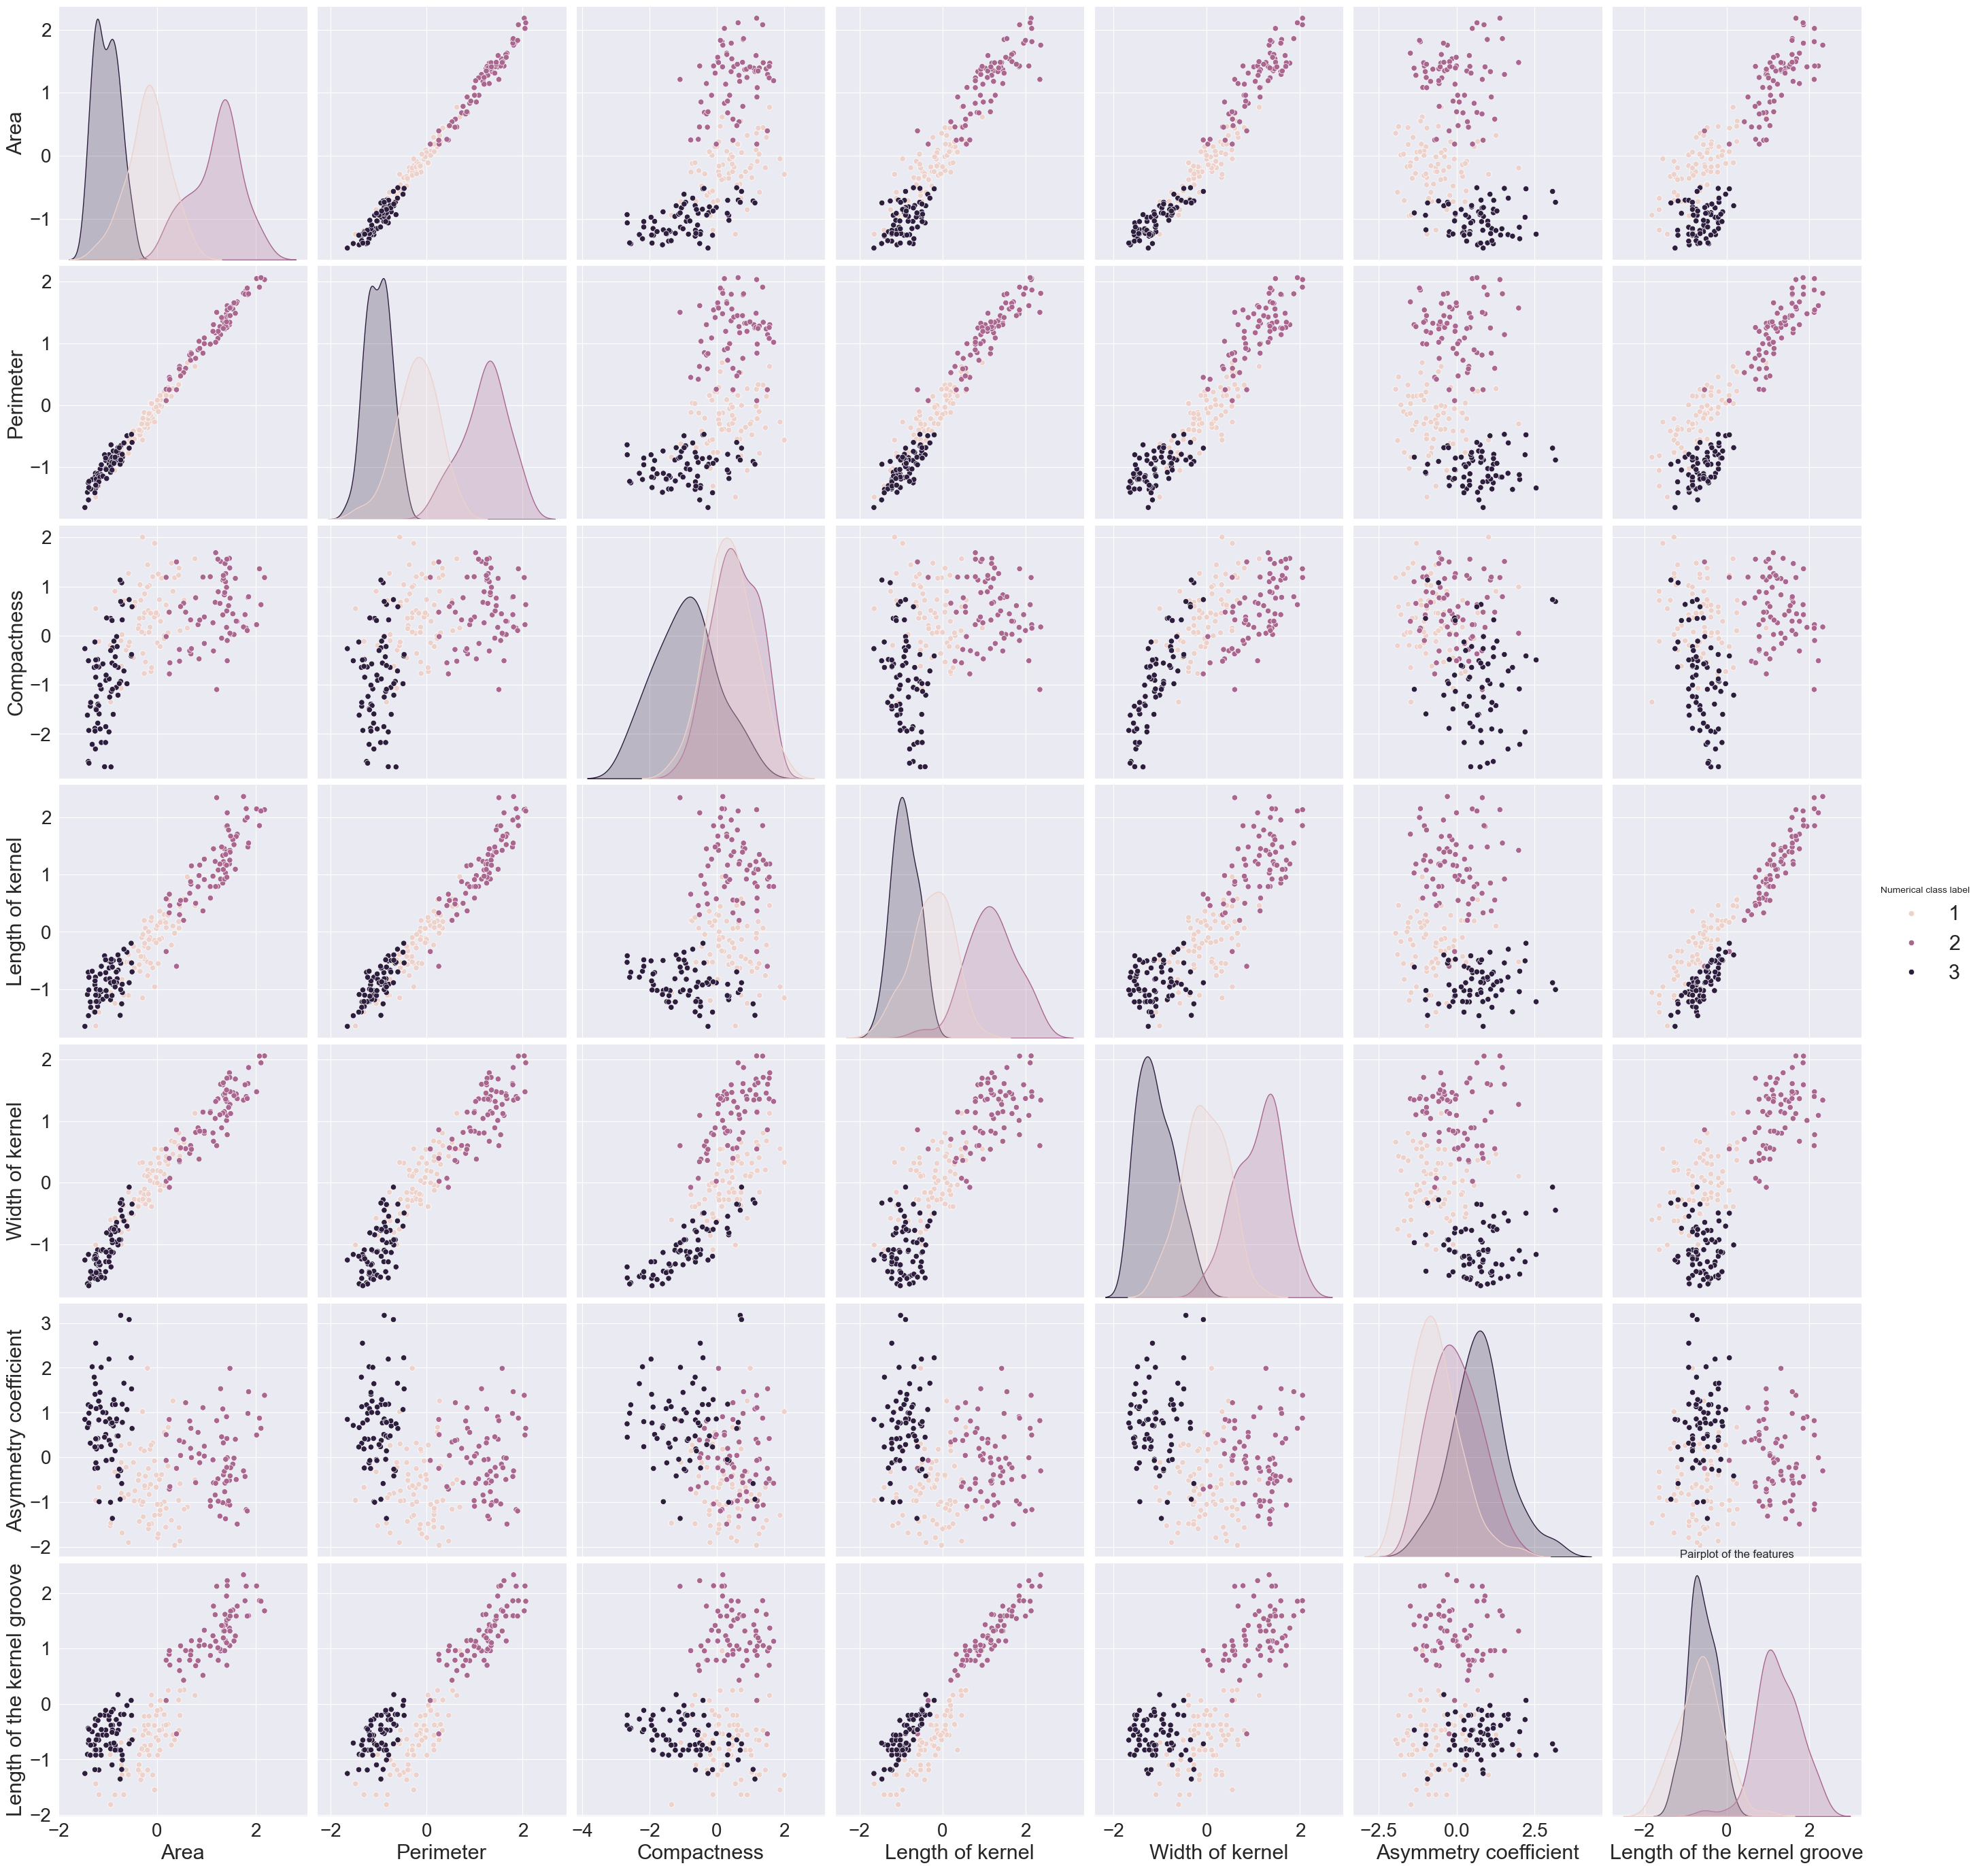

In [76]:
import seaborn as sns

sns.pairplot(
	scaled_df,
	hue="Numerical class label",
	height=4
)
plt.title("Pairplot of the features")
plt.savefig("figures/features_pairplot.png")

Scatterplot of one particular pair of features:

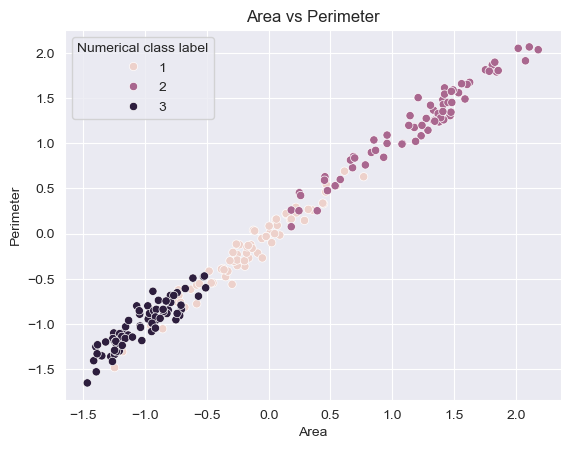

In [49]:
sns.scatterplot(
	x="Area",
	y="Perimeter",
	data=scaled_df,
	hue="Numerical class label",
)
plt.title("Area vs Perimeter")
plt.savefig("figures/area_perimeter_scatterplot.png")

Scatterplot the Gaussian random projections of the dataset, coloring the points according to the cluster they belong to:

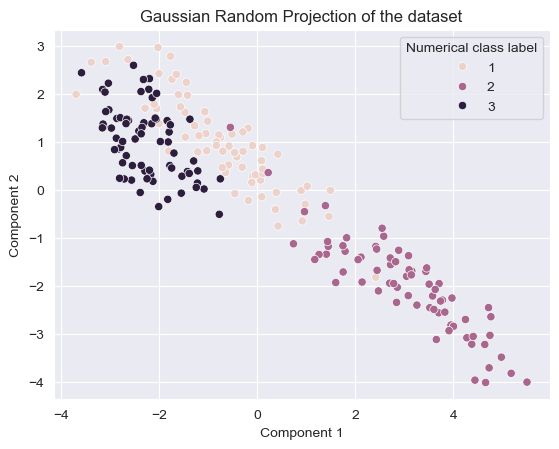

In [50]:
from sklearn.random_projection import \
	GaussianRandomProjection

embedding = GaussianRandomProjection(
	random_state=42, n_components=2
).fit_transform(scaled_data)

sns.scatterplot(
	x=embedding[:, 0],
	y=embedding[:, 1],
	hue=df["Numerical class label"]
)
plt.title("Gaussian Random Projection of the dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.savefig(
	"figures/gaussian_random_projection.png"
)

Scatterplot the UMAP projections of the dataset, coloring the points according to the cluster they belong to:

/Users/giacomo/.miniforge/envs/ds/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


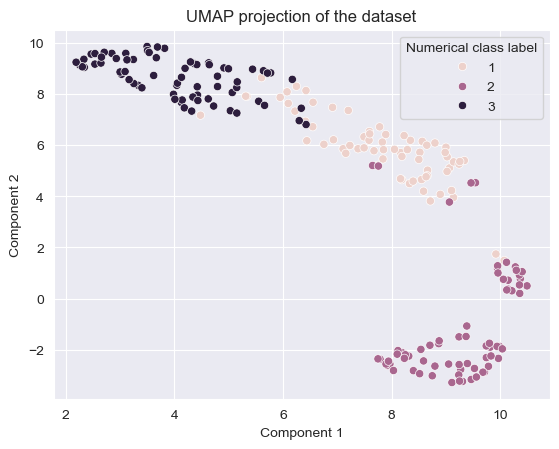

In [51]:
from umap import UMAP

embedding = UMAP(
	random_state=42, n_components=2
).fit_transform(scaled_data)

sns.scatterplot(
	x=embedding[:, 0],
	y=embedding[:, 1],
	hue=df["Numerical class label"]
)
plt.title("UMAP projection of the dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.savefig("figures/umap_projection.png")

## Evaluating clustering

Cluster the dataset using the optimal number of clusters:

In [52]:
k = scaled_df["Numerical class label"].nunique()

kmeans = KMeans(
	n_clusters=k,
	random_state=0,
	n_init="auto"
).fit(scaled_data)

Compute the rand index:

In [53]:
from sklearn.metrics import rand_score, \
	accuracy_score

rand_index = rand_score(
	scaled_df["Numerical class label"],
	kmeans.labels_
)
print(f"Rand index: {rand_index:.3f}")

Rand index: 0.900


Compute the accuracy by finding the maximum accuracy on all the cluster labels permutations:

In [54]:
def compute_accuracy(y_true, y_pred):
	max_accuracy = float('-inf')
	combinations = list(
		itertools.permutations(range(1, k + 1))
	)
	for combination in combinations:
		transformed_labels = np.array(
			[combination[label] for label in y_pred]
		)
		max_accuracy = max(
			max_accuracy,
			accuracy_score(y_true, transformed_labels)
		)
	return max_accuracy


accuracy = compute_accuracy(
	scaled_df["Numerical class label"],
	kmeans.labels_
)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.919


### Agglomerative clustering

Hierarchically cluster the dataset with all the linkage methods:

In [55]:
from sklearn.cluster import \
	AgglomerativeClustering

best_method = None
best_accuracy = float('-inf')
linkage_methods = [
	"ward",
	"complete",
	"average",
	"single"
]
for method in linkage_methods:
	cluster = AgglomerativeClustering(
		n_clusters=k,
		linkage=method
	).fit(scaled_data)
	accuracy = compute_accuracy(
		scaled_df["Numerical class label"],
		cluster.labels_
	)

	if accuracy > best_accuracy:
		best_accuracy = accuracy
		best_method = method

	print(
		f"Accuracy for linkage method {method}: {accuracy:.3f}"
	)

print(f"Best linkage method: {best_method}")

Accuracy for linkage method ward: 0.929
Accuracy for linkage method complete: 0.876
Accuracy for linkage method average: 0.881
Accuracy for linkage method single: 0.348
Best linkage method: ward


Plot the dendrogram for the best linkage method:

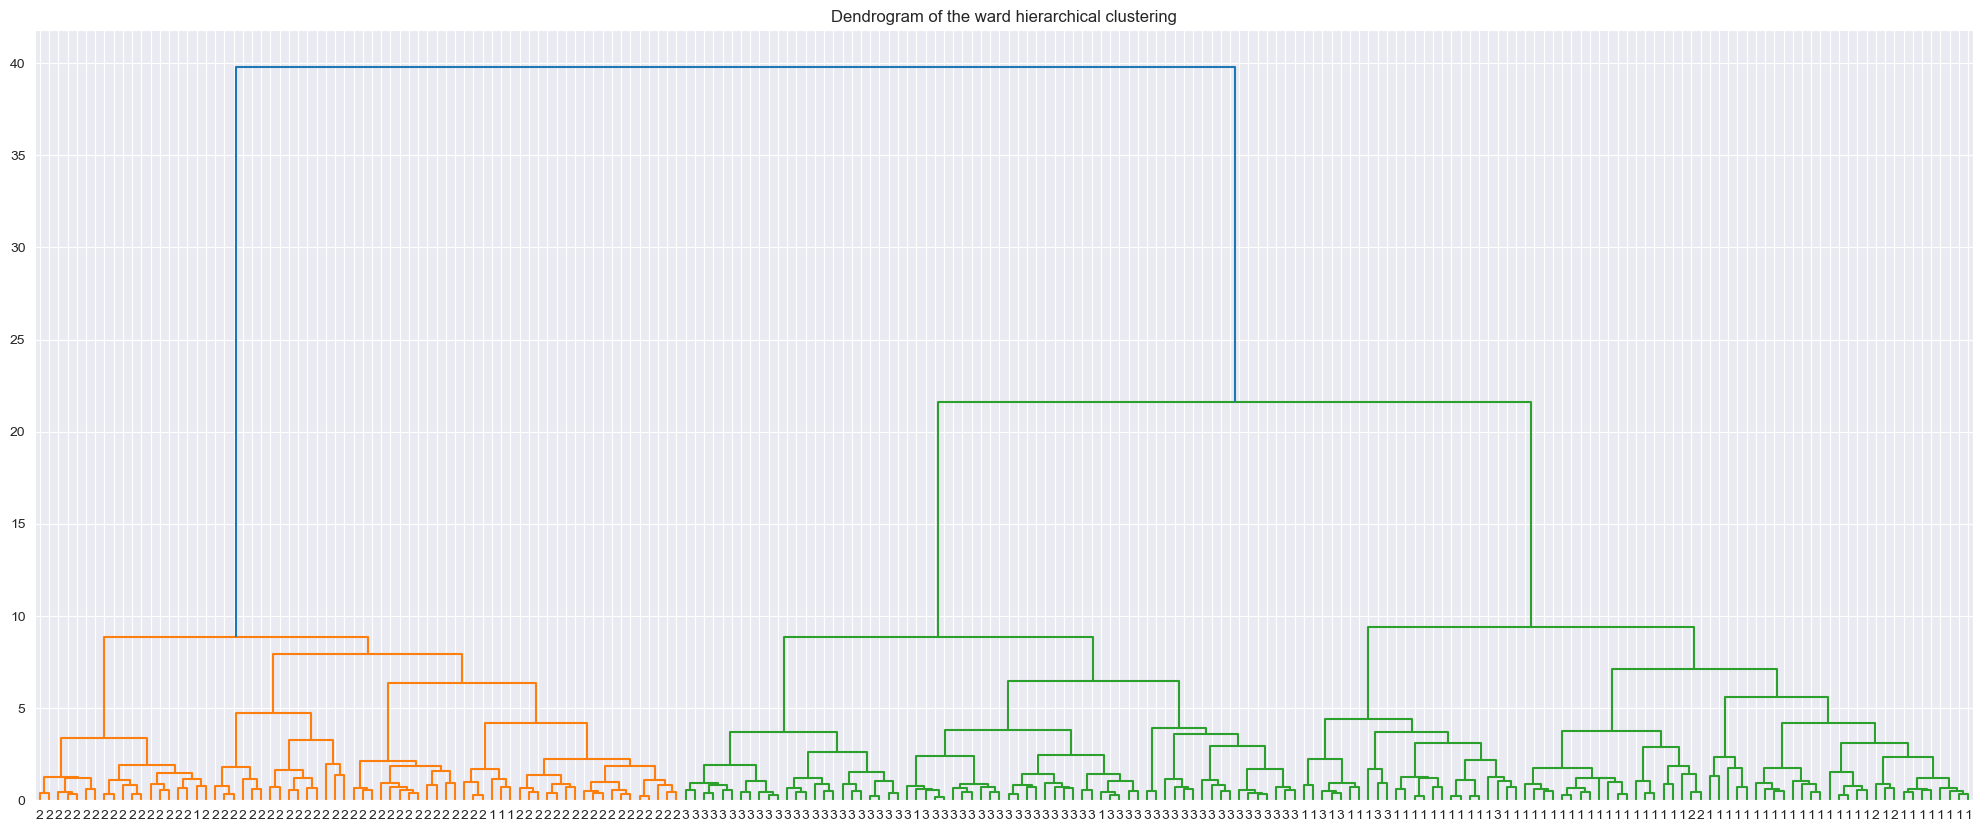

In [56]:
from scipy.cluster.hierarchy import dendrogram, \
	linkage

plt.figure(figsize=(25, 10))
dendrogram(
	linkage(scaled_data, method=best_method),
	labels=scaled_df[
		"Numerical class label"
	].values,
	leaf_font_size=10,
	leaf_rotation=0
)
plt.title("Dendrogram of the ward hierarchical clustering")
plt.savefig("figures/dendrogram.png")